# Analysis of the Wine Quality Results

In [161]:
%pwd

'/workspaces/expainable-uncertainty-quantification'

In [162]:
'/workspaces/expainable-uncertainty-quantification/notebooks'

'/workspaces/expainable-uncertainty-quantification/notebooks'

In [163]:
%cd /workspaces/expainable-uncertainty-quantification

/workspaces/expainable-uncertainty-quantification


/workspaces/expainable-uncertainty-quantification/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [164]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import scienceplots 

from matplotlib.ticker import FuncFormatter, LogFormatterMathtext
from scipy.stats import spearmanr

import matplotlib as mpl

mpl.rcParams.update(
    {
        "font.family": "DejaVu Sans",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 12,
        "mathtext.fontset": "dejavusans",
    }
)

Load results. The results should be in aggregated form. Run "data_collection_winequality" to obtain the aggregated results.

In [165]:
def load_results(pickle_path):
    with open(pickle_path, 'rb') as f:
            return pickle.load(f)

In [166]:
complexity = load_results("results_final_winequality/aggregated/complexity_aggregated.pkl")
determinism = load_results("results_final_winequality/aggregated/determinism_aggregated.pkl")
featureflipping = load_results("results_final_winequality/aggregated/feature_flipping_aggregated.pkl")
ris = load_results("results_final_winequality/aggregated/relative_input_stability_aggregated.pkl")
rri = load_results("results_final_winequality/aggregated/relative_rank_improvement_aggregated.pkl")
ucs = load_results("results_final_winequality/aggregated/uncertainty_conveyance_similarity_aggregated.pkl")

# Plots

In [167]:
plt.style.use(['science', "ieee", "no-latex", "muted" ]) 

In [ ]:
def plot_metrics_by_method_all_values(dicts, metrics_all_values, nrows=2, ncols=4, figsize=(12, 8), title=None):

    (complexity, determinism, featureflipping, ris, rri, ucs) = dicts
    first_agg = complexity
    uq_keys = sorted(first_agg.keys())
    xai_methods = list(first_agg[uq_keys[0]].keys())
    uq_methods = ["dropout_01", "dropconnect_03"]

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i, (metric_name, metric_dict, metric_value, direction) in enumerate(metrics_all_values):
        ax = axes[i]
        rows = []
        for uq in uq_methods:
            for xai in xai_methods:
                if uq not in metric_dict:
                    continue
                if xai not in metric_dict[uq]:
                    continue
                vals_list = metric_dict[uq][xai].get(metric_value)
                if vals_list is None:
                    continue
                # vals_list is expected to be a list-of-lists (one per fold)
                try:
                    flat = []
                    for sub in vals_list:
                        if sub is None:
                            continue
                        flat.extend(list(sub))
                except Exception:
                    # fall back to treating it as a single list
                    flat = list(vals_list)

                for v in flat:
                    if v is None:
                        continue
                    rows.append({"XAI": xai, "UQ": uq, "value": v})

        df = pd.DataFrame(rows)
        if df.empty:
            ax.set_title(metric_name + " (no data)")
            continue

        sns.boxplot(data=df, x="XAI", y="value", hue="UQ", ax=ax,showfliers=False )
        arrow = ""
        if direction == "higher":
            arrow = r" $\uparrow$"
        elif direction == "lower":
            arrow = r" $\downarrow$"
        ax.set_title(metric_name + arrow)
        ax.set_xlabel("")
        ax.set_ylabel("Value")
        ax.tick_params(axis="x", rotation=45)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    for k in range(len(metrics_all_values), nrows * ncols):
        axes[k].axis("off")

    if title:
        plt.suptitle(title)
    plt.tight_layout()
    return fig, axes


(<Figure size 9600x4800 with 8 Axes>,
 array([<Axes: title={'center': 'Complexity $\\downarrow$'}, ylabel='Value'>,
        <Axes: title={'center': 'Repeatability Cosine $\\uparrow$'}, ylabel='Value'>,
        <Axes: title={'center': 'Repeatability Spearman $\\uparrow$'}, ylabel='Value'>,
        <Axes: title={'center': 'Feature Flipping $\\downarrow$'}, ylabel='Value'>,
        <Axes: title={'center': 'RIS $\\downarrow$'}, ylabel='Value'>,
        <Axes: title={'center': 'RRI $\\uparrow$'}, ylabel='Value'>,
        <Axes: title={'center': 'UCS Cosine $\\uparrow$'}, ylabel='Value'>,
        <Axes: title={'center': 'UCS Spearman $\\uparrow$'}, ylabel='Value'>],
       dtype=object))

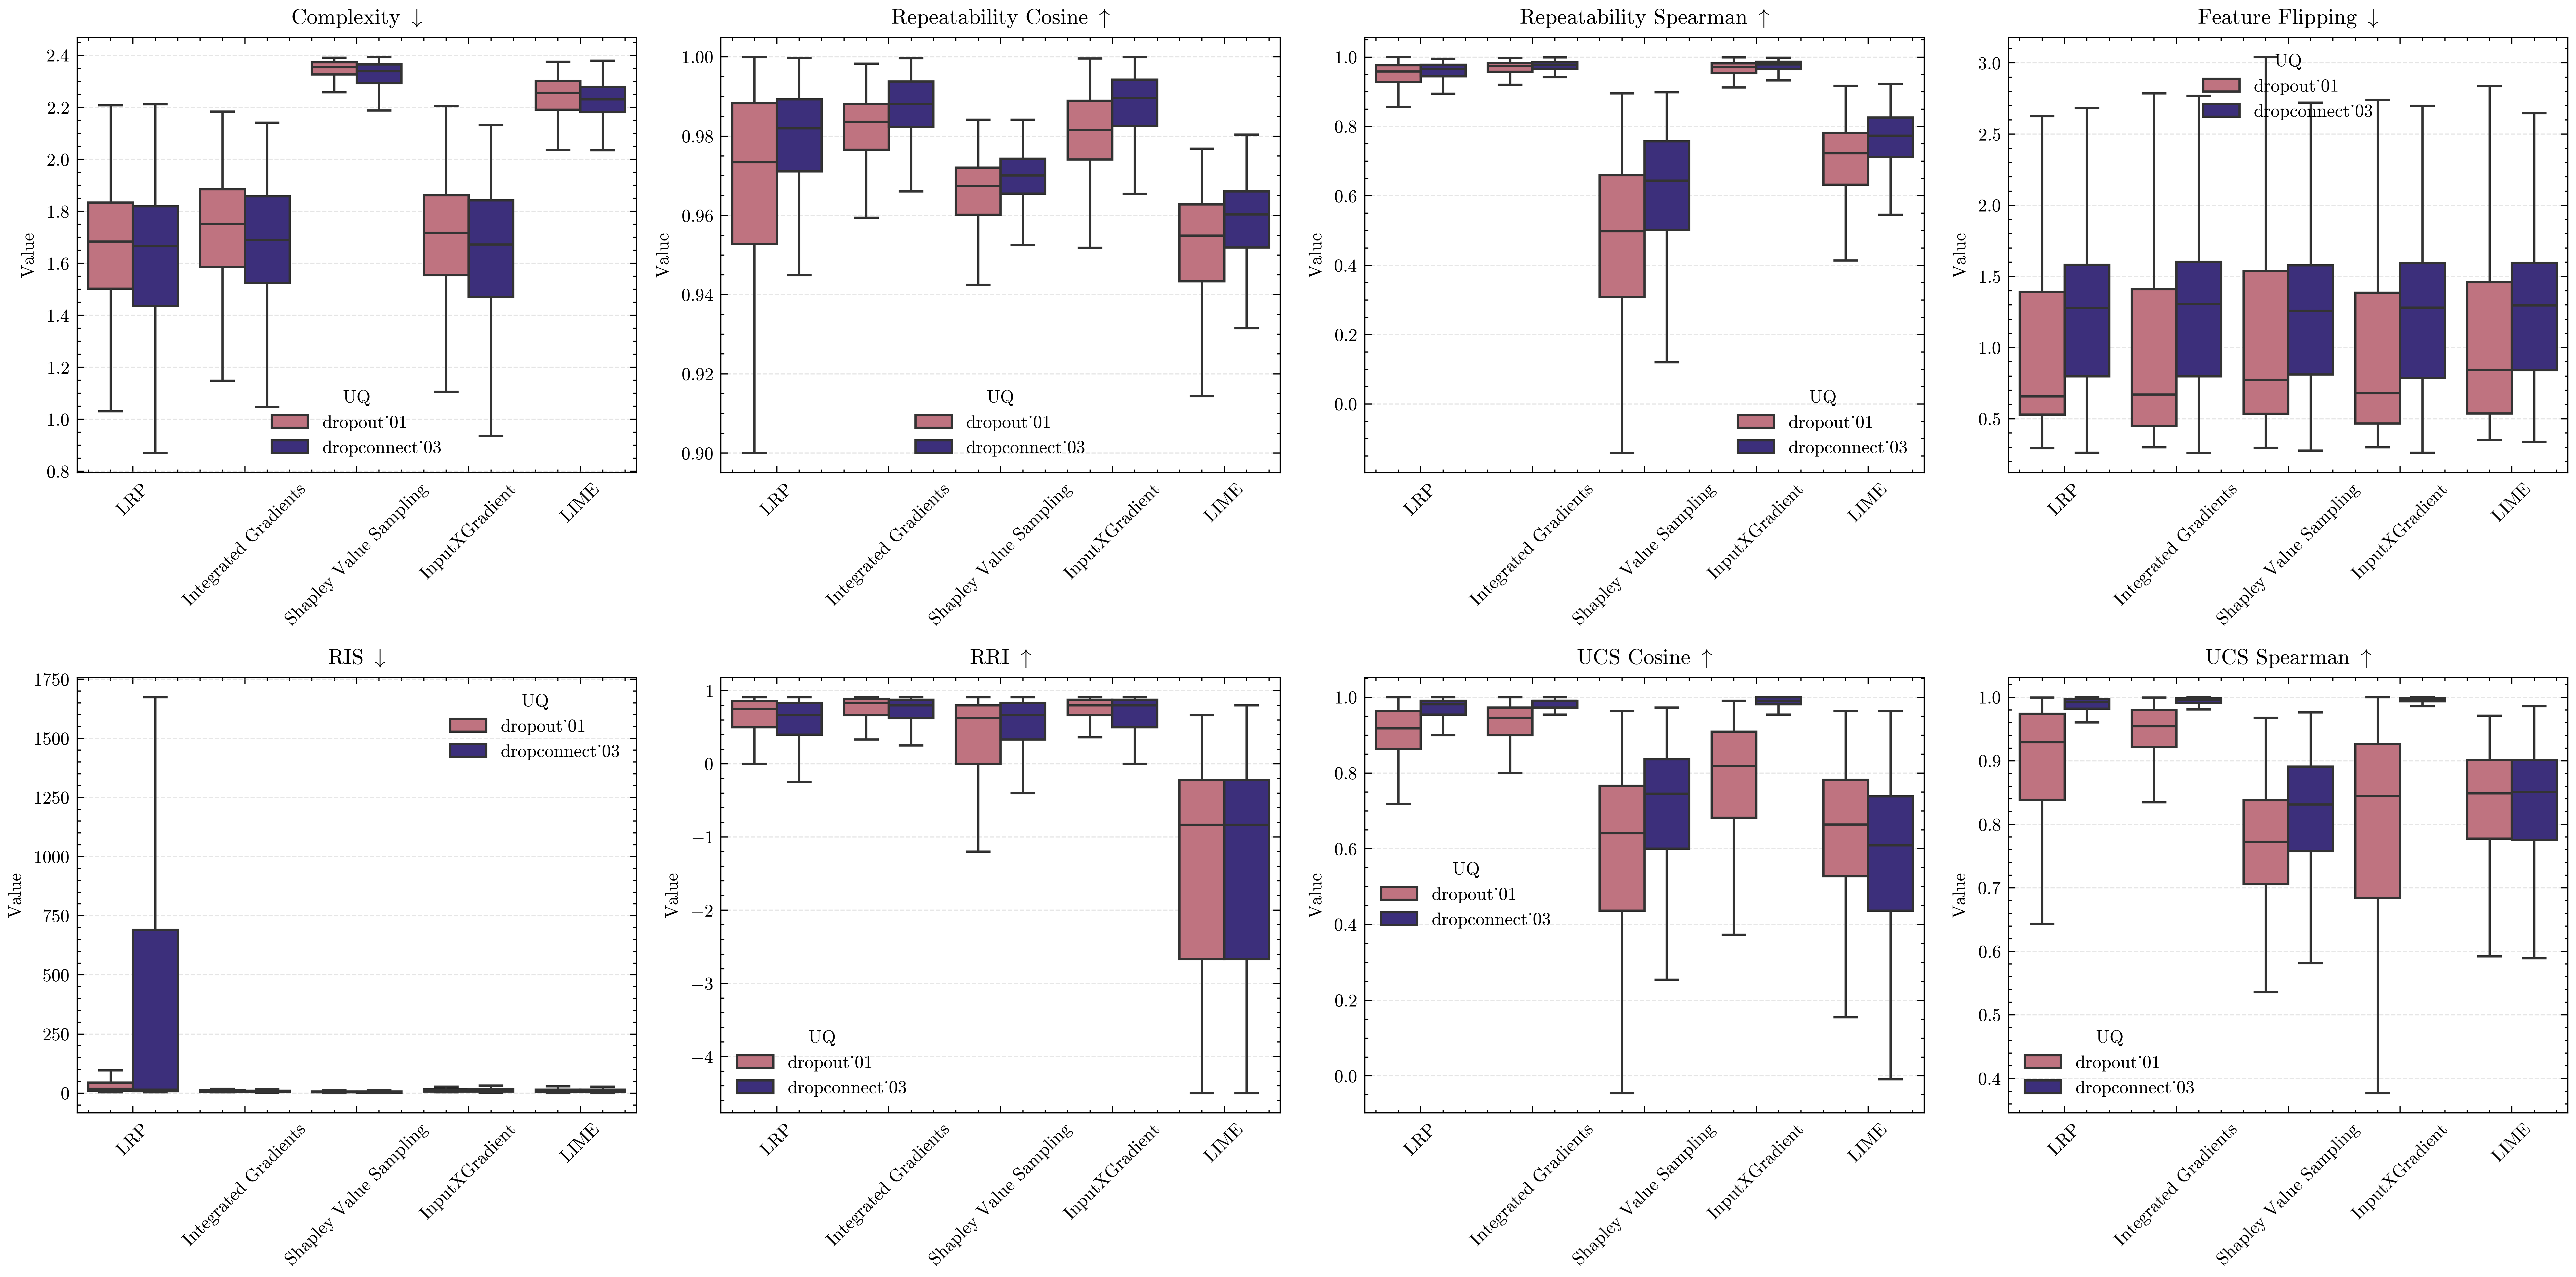

In [ ]:
dicts = (complexity, determinism, featureflipping, ris, rri, ucs)
metrics_all_values = [("Complexity", complexity, "all_values", "lower"), ("Repeatability Cosine", determinism, "all_values_cosine", "higher"), ("Repeatability Spearman", determinism, "all_values_spearman", "higher"), ("Feature Flipping", featureflipping, "all_values", "lower"),
                      ("RIS", ris, "all_values", "lower"), ("RRI", rri, "rank_changes", "higher"), ("UCS Cosine", ucs, "all_values_cosine", "higher"), ("UCS Spearman", ucs, "all_values_spearman", "higher")]

plot_metrics_by_method_all_values(dicts, metrics_all_values, nrows=2, ncols=4, figsize=(16, 8))

In [ ]:
def plot_metrics_violin_by_method_all_values(dicts, metrics_all_values, nrows=2, ncols=4, figsize=(12, 8), title=None):

    (complexity, determinism, featureflipping, ris, rri, ucs) = dicts
    first_agg = complexity
    uq_keys = sorted(first_agg.keys())
    xai_methods = list(first_agg[uq_keys[0]].keys())
    uq_methods = ["dropout_01", "dropconnect_03"]

    xai_methods_labels = ["LRP", "IG", "SHAP", "IxG", "LIME"]
    label_map = {orig: lab for orig, lab in zip(xai_methods, xai_methods_labels)}

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i, (metric_name, metric_dict, metric_value, direction) in enumerate(metrics_all_values):
        ax = axes[i]
        rows = []
        for uq in uq_methods:
            for xai in xai_methods:
                if uq not in metric_dict:
                    continue
                if xai not in metric_dict[uq]:
                    continue
                vals_list = metric_dict[uq][xai].get(metric_value)
                if vals_list is None:
                    continue
                try:
                    flat = []
                    for sub in vals_list:
                        if sub is None:
                            continue
                        flat.extend(list(sub))
                except Exception:
                    flat = list(vals_list)

                for v in flat:
                    if v is None:
                        continue
                    rows.append({"XAI": xai, "UQ": uq, "value": v})

        df = pd.DataFrame(rows)
        if df.empty:
            ax.set_title(metric_name + " (no data)")
            ax.set_xlabel("")
            continue

        present_order = [m for m in xai_methods if m in df["XAI"].unique()]

        sns.violinplot(data=df, x="XAI", y="value", hue="UQ", order=present_order, ax=ax, inner="quartile", cut=0, scale="width")
        if present_order:
            ax.set_xticklabels([label_map.get(m, m) for m in present_order], rotation=45)
        arrow = ""
        if direction == "higher":
            arrow = r" $\uparrow$"
        elif direction == "lower":
            arrow = r" $\downarrow$"
        ax.set_title(metric_name + arrow)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(axis="y", linestyle="--", alpha=0.3)

        lg = ax.get_legend()
        if lg is not None:
            lg.remove()

    for k in range(len(metrics_all_values), nrows * ncols):
        axes[k].axis("off")

    if title:
        plt.suptitle(title)
    plt.tight_layout()
    return fig, axes


/tmp/ipykernel_13131/661977436.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="XAI", y="value", hue="UQ", order=present_order, ax=ax, inner="quartile", cut=0, scale="width")
/tmp/ipykernel_13131/661977436.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_map.get(m, m) for m in present_order], rotation=45)
/tmp/ipykernel_13131/661977436.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="XAI", y="value", hue="UQ", order=present_order, ax=ax, inner="quartile", cut=0, scale="width")
/tmp/ipykernel_13131/661977436.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fixe

(<Figure size 9600x4800 with 8 Axes>,
 array([<Axes: title={'center': 'Complexity $\\downarrow$'}>,
        <Axes: title={'center': 'Repeatability Cosine $\\uparrow$'}>,
        <Axes: title={'center': 'Repeatability Spearman $\\uparrow$'}>,
        <Axes: title={'center': 'Feature Flipping $\\downarrow$'}>,
        <Axes: title={'center': 'RIS $\\downarrow$'}>,
        <Axes: title={'center': 'RRI $\\uparrow$'}>,
        <Axes: title={'center': 'UCS Cosine $\\uparrow$'}>,
        <Axes: title={'center': 'UCS Spearman $\\uparrow$'}>], dtype=object))

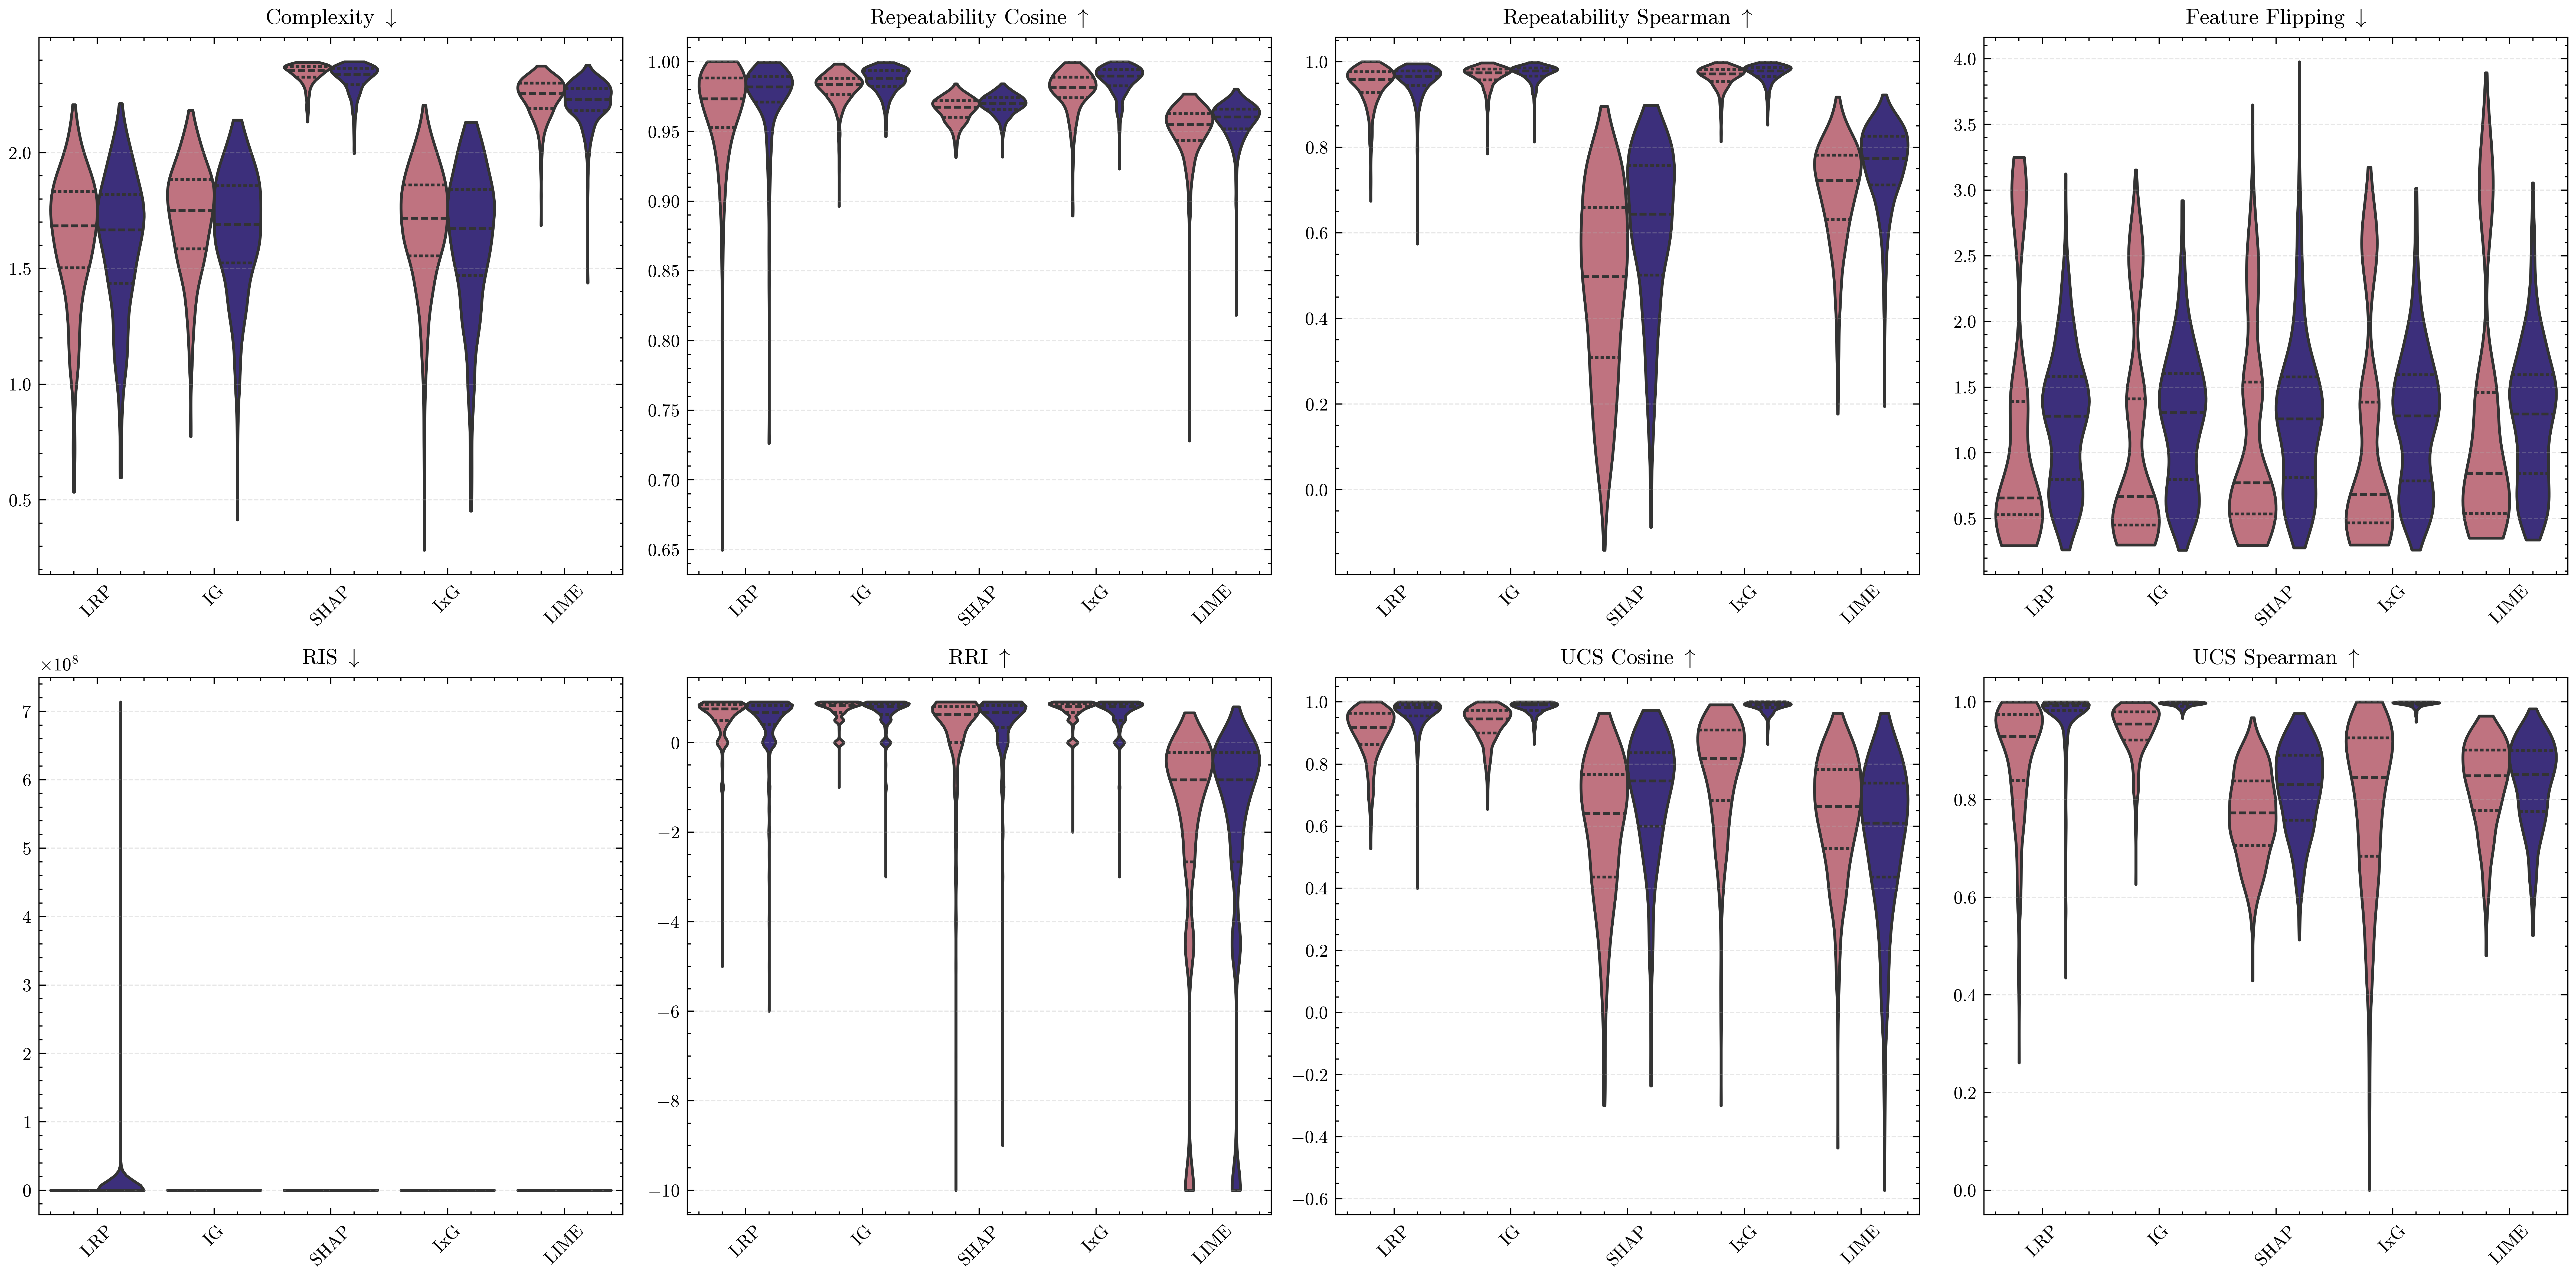

In [189]:
dicts = (complexity, determinism, featureflipping, ris, rri, ucs)
metrics_all_values = [("Complexity", complexity, "all_values", "lower"), ("Repeatability Cosine", determinism, "all_values_cosine", "higher"), ("Repeatability Spearman", determinism, "all_values_spearman", "higher"), ("Feature Flipping", featureflipping, "all_values", "lower"),
                      ("RIS", ris, "all_values", "lower"), ("RRI", rri, "rank_changes", "higher"), ("UCS Cosine", ucs, "all_values_cosine", "higher"), ("UCS Spearman", ucs, "all_values_spearman", "higher")]

plot_metrics_violin_by_method_all_values(dicts, metrics_all_values, nrows=2, ncols=4, figsize=(16, 8))

In [ ]:
def plot_metrics_dot_by_method_all_values(
    dicts,
    metrics_all_values,
    nrows=2,
    ncols=4,
    figsize=(12, 8),
    title=None,
    title_fontsize=20,
    xtick_fontsize=18,
    ytick_fontsize=None,
):
    """
    Draw dotplots (mean per-sample value) with 95% CI errorbars per XAI method,
    grouped by UQ method. 
    """
    try:
        from scipy.stats import t as t_dist
    except Exception:
        t_dist = None


    if ytick_fontsize is None:
        ytick_fontsize = xtick_fontsize

    (complexity, determinism, featureflipping, ris, rri, ucs) = dicts
    first_agg = complexity
    uq_keys = sorted(first_agg.keys())
    xai_methods = list(first_agg[uq_keys[0]].keys())

    preferred_xai_order = [
        "LRP",
        "Integrated Gradients",
        "InputXGradient",
        "Shapley Value Sampling",
        "LIME"
    ]
    label_map = {
        "LRP": "LRP",
        "Integrated Gradients": "IG",
        "InputXGradient": "IxG",
        "Shapley Value Sampling": "SHAP",
        "LIME": "LIME",
    }

    enumeration = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

    uq_methods = ["dropout_01", "dropconnect_03"]

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    alpha = 0.05  # 95% CI
    marker_kwargs = dict(marker="o", linestyle="None", markersize=7)

    def fmt_1(x, pos):
        return f"{x:.1f}"

    def fmt_2(x, pos):
        return f"{x:.2f}"

    def fmt_3(x, pos):
        return f"{x:.3f}"

    def fmt_4(x, pos):
        return f"{x:.4f}"

    explicit_ticks = {
        "complexity": [1.5, 2.0, 2.5, 3.0],
        "repeatability cosine": [0.94, 0.96, 0.98, 1.00],
        "repeatability spearman": [0.40, 0.60, 0.80, 1.00],
        "feature flipping": [0.80, 1.00, 1.20, 1.40],
        "ris": [1e0, 1e3, 1e6, 1e9],
        "rri": [-2.4, -1.2, 0.00, 1.2],
        "ucs cosine": [0.40, 0.60, 0.80, 1.0],
        "ucs spearman": [0.70, 0.80, 0.90, 1.0],
    }

    for i, entry in enumerate(metrics_all_values):
        try:
            metric_name, metric_dict, metric_value, direction = entry[0], entry[1], entry[2], entry[3]
        except Exception:
            continue

        ax = axes[i]
        rows = []
        for uq in uq_methods:
            for xai in xai_methods:
                if uq not in metric_dict:
                    continue
                if xai not in metric_dict[uq]:
                    continue
                vals_list = metric_dict[uq][xai].get(metric_value)
                if vals_list is None:
                    continue
                try:
                    flat = []
                    for sub in vals_list:
                        if sub is None:
                            continue
                        flat.extend(list(sub))
                except Exception:
                    flat = list(vals_list)

                for v in flat:
                    if v is None:
                        continue
                    rows.append({"XAI": xai, "UQ": uq, "value": v})

        df = pd.DataFrame(rows)
        if df.empty:
            ax.set_title(metric_name + " (no data)", fontsize=title_fontsize)
            ax.set_xlabel("", fontsize=xtick_fontsize)
            continue

        present_order = [m for m in preferred_xai_order if m in df["XAI"].unique()]
        if not present_order:
            present_order = [m for m in xai_methods if m in df["XAI"].unique()]

        df_group = (
            df.groupby(["XAI", "UQ"], sort=False)["value"]
            .agg(["mean", "std", "count"])
            .reset_index()
            .rename(columns={"mean": "value_mean", "std": "value_std", "count": "n"})
        )

        def compute_ci_half(std, n):
            if n is None or n <= 1 or pd.isna(std):
                return 0.0
            sem = std / math.sqrt(n)
            if t_dist is not None:
                try:
                    crit = float(t_dist.ppf(1 - alpha / 2, df=int(n) - 1))
                except Exception:
                    crit = 1.96
            else:
                crit = 1.96
            return sem * crit

        df_group["value_ci"] = df_group.apply(lambda r: compute_ci_half(r["value_std"], r["n"]), axis=1)

        if metric_name == "RIS":
            if (df_group["value_mean"] <= 0).any():
                eps = (
                    df_group["value_mean"][df_group["value_mean"] > 0].min() * 1e-3
                    if (df_group["value_mean"] > 0).any()
                    else 1e-6
                )
                df_group["value_mean"] = df_group["value_mean"].clip(lower=eps)

        x_positions = list(range(len(present_order)))
        n_uq = len(uq_methods)
        width = 0.18

        palette = sns.color_palette(n_colors=n_uq)
        legend_handles = []
        from matplotlib.lines import Line2D

        for uq_idx, uq in enumerate(uq_methods):
            xs = []
            ys = []
            yerrs = []
            for xi, xai in enumerate(present_order):
                sub = df_group[(df_group["XAI"] == xai) & (df_group["UQ"] == uq)]
                if sub.empty:
                    xs.append(None)
                    ys.append(None)
                    yerrs.append(0.0)
                else:
                    mean_val = float(sub["value_mean"].values[0])
                    ci_val = float(sub["value_ci"].values[0]) if not pd.isna(sub["value_ci"].values[0]) else 0.0
                    x_off = (uq_idx - (n_uq - 1) / 2.0) * width
                    xs.append(xi + x_off)
                    ys.append(mean_val)
                    yerrs.append(ci_val)

            valid = [k for k, y in enumerate(ys) if y is not None]
            if valid:
                xs_valid = [xs[k] for k in valid]
                ys_valid = [ys[k] for k in valid]
                yerrs_valid = [yerrs[k] for k in valid]
                if "feature" in metric_name.lower() and "flip" in metric_name.lower():
                    lower_errs = [max(min(ci, y), 0.0) for ci, y in zip(yerrs_valid, ys_valid)]
                    upper_errs = yerrs_valid
                    yerr_array = [lower_errs, upper_errs]
                    ax.errorbar(xs_valid, ys_valid, yerr=yerr_array, color=palette[uq_idx], capsize=3, **marker_kwargs)
                else:
                    ax.errorbar(xs_valid, ys_valid, yerr=yerrs_valid, color=palette[uq_idx], capsize=3, **marker_kwargs)

            legend_handles.append(Line2D([0], [0], marker="o", color=palette[uq_idx], linestyle="None", markersize=6))

        ax.set_xticks(x_positions)
        ax.set_xticklabels([label_map.get(m, m) for m in present_order], rotation=45, fontsize=xtick_fontsize)

        key = metric_name.strip().lower()
        ticks = None
        if key in explicit_ticks:
            ticks = explicit_ticks[key]
        else:
            for kname in explicit_ticks:
                if kname in key:
                    ticks = explicit_ticks[kname]
                    break

        if ticks is not None:
            if key == "ris" or "ris" in key:
                ax.set_yscale("log")
                ticks_arr = np.array(ticks)
                ax.set_yticks(ticks_arr)
                ax.set_ylim(ticks_arr[0], ticks_arr[-1])
                ax.yaxis.set_major_formatter(LogFormatterMathtext())
            else:
                ticks_arr = np.array(ticks)
                ax.set_yticks(ticks_arr)
                ax.set_ylim(ticks_arr[0], ticks_arr[-1])
                if key == "complexity":
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_1(x, pos)))
                elif "repeatability cosine" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_3(x, pos)))
                elif "repeatability spearman" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_4(x, pos)))
                elif "feature flipping" in key or "feature flipping" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
                elif "rri" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
                elif "ucs" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
                else:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
            ax.tick_params(axis="y", labelsize=ytick_fontsize, labelleft=True)
        else:
            try:
                ymin, ymax = ax.get_ylim()
                ticks_lin = np.linspace(ymin, ymax, num=5)
                ax.set_yticks(ticks_lin)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_3(x, pos)))
                ax.set_ylim(ticks_lin[0], ticks_lin[-1])
            except Exception:
                pass

        arrow = ""
        if direction == "higher":
            arrow = r" $\uparrow$"
        elif direction == "lower":
            arrow = r" $\downarrow$"

        if key == "ris" or "ris" in key:
            ax.set_title(str(enumeration[i]) + " " + metric_name + " (log scale)" + arrow, fontsize=title_fontsize, y=1.06)
        else:
            ax.set_title(str(enumeration[i]) + " " + metric_name + arrow, fontsize=title_fontsize, y=1.06)

        ax.set_xlabel("", fontsize=xtick_fontsize)
        ax.set_ylabel("", fontsize=xtick_fontsize)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

        if legend_handles:
            if not hasattr(fig, "_dot_legend_handles"):
                fig._dot_legend_handles = legend_handles # type: ignore
                fig._dot_legend_labels = ["dropout, p = 0.1", "dropconnect, p = 0.3"][: len(legend_handles)] # type: ignore

    for k in range(len(metrics_all_values), nrows * ncols):
        axes[k].axis("off")

    if hasattr(fig, "_dot_legend_handles"):
        fig.legend(fig._dot_legend_handles, fig._dot_legend_labels, loc="upper left", bbox_to_anchor=(0, 1.07), ncol=max(1, len(fig._dot_legend_labels)), fontsize = 20) # type: ignore
        fig.tight_layout(rect=(0, 0.06, 1, 1))
    else:
        fig.tight_layout()

    if title:
        plt.suptitle(title, fontsize=title_fontsize)
        fig.subplots_adjust(top=0.92)

    return fig, axes


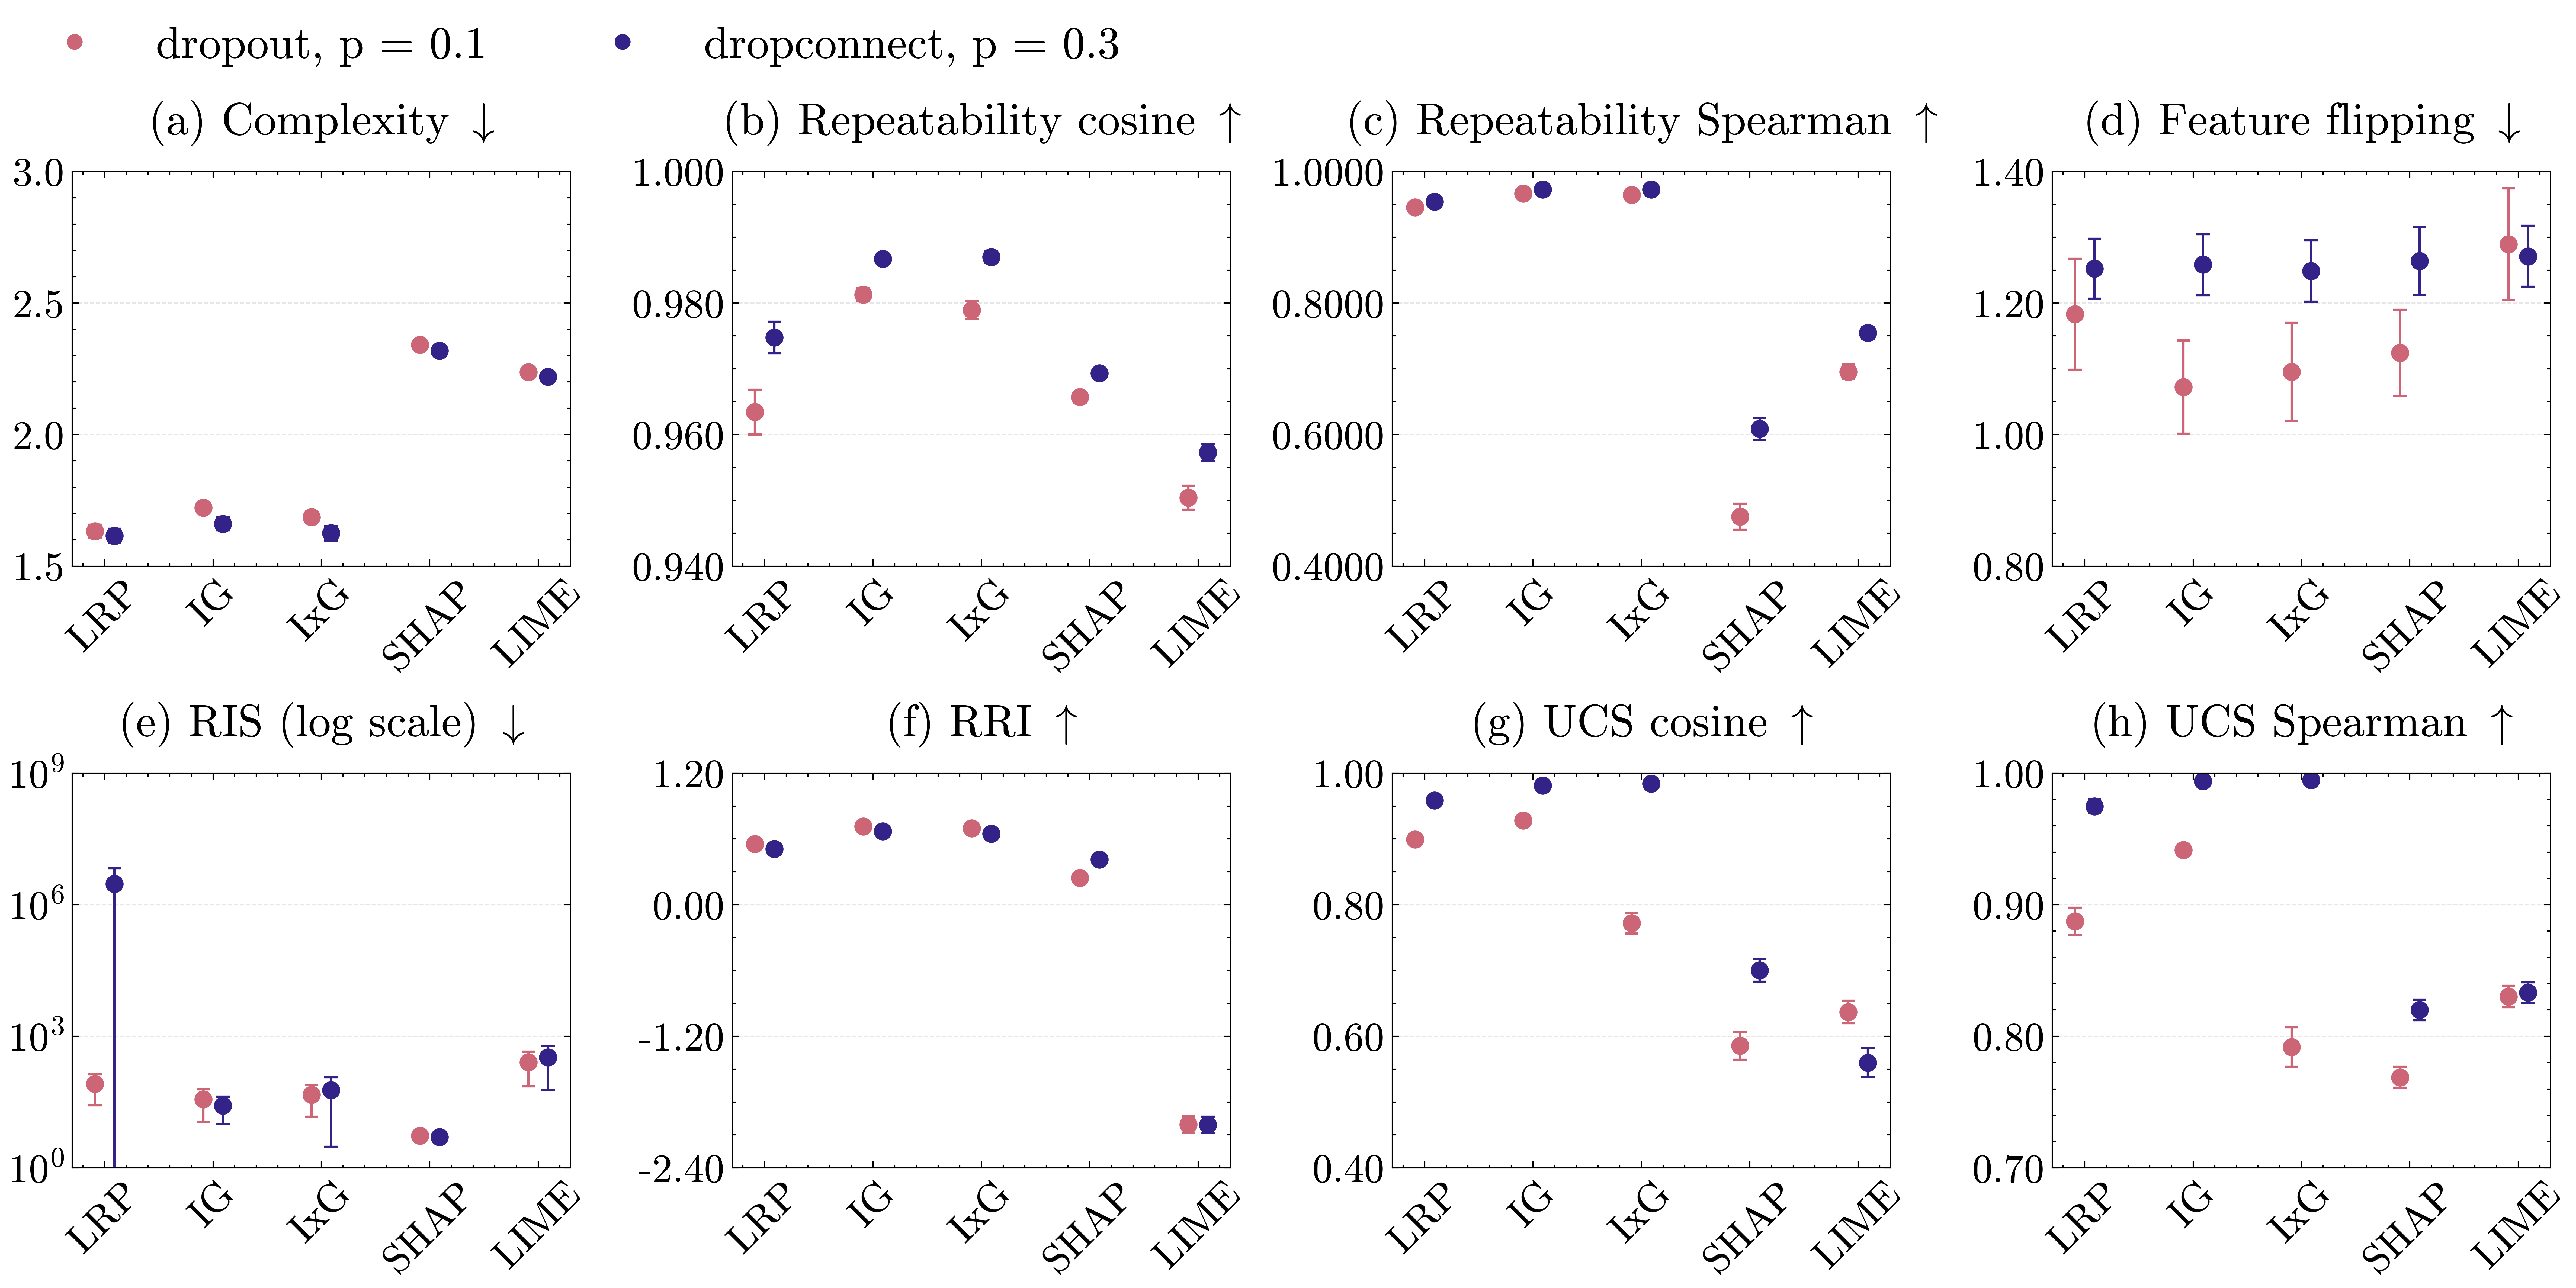

In [191]:
metrics_all_values = [("Complexity", complexity, "all_values", "lower"), ("Repeatability cosine", determinism, "all_values_cosine", "higher"), ("Repeatability Spearman", determinism, "all_values_spearman", "higher"), ("Feature flipping", featureflipping, "all_values", "lower"),
                      ("RIS", ris, "all_values", "lower"), ("RRI", rri, "rank_changes", "higher"), ("UCS cosine", ucs, "all_values_cosine", "higher"), ("UCS Spearman", ucs, "all_values_spearman", "higher")]
fig, axs = plot_metrics_dot_by_method_all_values(dicts, metrics_all_values, nrows=2, ncols=4, figsize=(16, 8), title="")

fig.savefig("/workspaces/expainable-uncertainty-quantification/output/winequality_dotplots.pdf", dpi=300, bbox_inches="tight")

# Get average metric scores per uncertainty attribution method

In [192]:
metrics = [("Complexity", complexity, "mean", "lower"), ("Repeatability Cosine", determinism, "mean_cosine", "higher"), ("Repeatability Spearman", determinism, "mean_spearman", "higher"), ("Feature Flipping", featureflipping, "auc_mean", "lower"),
           ("RIS", ris, "RIS_mean", "lower"), ("RRI", rri, "avg_unc_rank_change", "higher"), ("UCS Cosine", ucs, "mean_cosine", "higher"), ("UCS Spearman", ucs, "mean_spearman", "higher")]

methods = [
        "LRP",
        "Integrated Gradients",
        "InputXGradient",
        "Shapley Value Sampling",
        "LIME"
    ]
for (name, data, key, _) in metrics:
    for xai_method in methods:
        list_val_dropout = data["dropout_01"][xai_method][key]
        list_val_dropconnect = data["dropconnect_03"][xai_method][key]
        mean_dropout = np.mean(list_val_dropout)
        mean_dropconnect = np.mean(list_val_dropconnect)
        mean_dropout = np.round(mean_dropout,3)
        mean_dropconnect = np.round(mean_dropconnect, 3)
        print(f"{name}: {xai_method} - dropout: {mean_dropout}, dropconnect: {mean_dropconnect}")


Complexity: LRP - dropout: 1.6330000162124634, dropconnect: 1.6150000095367432
Complexity: Integrated Gradients - dropout: 1.7230000495910645, dropconnect: 1.6610000133514404
Complexity: InputXGradient - dropout: 1.6859999895095825, dropconnect: 1.625
Complexity: Shapley Value Sampling - dropout: 2.3410000801086426, dropconnect: 2.318000078201294
Complexity: LIME - dropout: 2.23799991607666, dropconnect: 2.2190001010894775
Repeatability Cosine: LRP - dropout: 0.963, dropconnect: 0.975
Repeatability Cosine: Integrated Gradients - dropout: 0.981, dropconnect: 0.987
Repeatability Cosine: InputXGradient - dropout: 0.979, dropconnect: 0.987
Repeatability Cosine: Shapley Value Sampling - dropout: 0.966, dropconnect: 0.969
Repeatability Cosine: LIME - dropout: 0.95, dropconnect: 0.957
Repeatability Spearman: LRP - dropout: 0.946, dropconnect: 0.954
Repeatability Spearman: Integrated Gradients - dropout: 0.966, dropconnect: 0.973
Repeatability Spearman: InputXGradient - dropout: 0.964, dropcon

# Compute sanity checks

In [178]:
def get_inter_rater_method_reliability(key_to_use, methods, metric_name, data, uq_methods):
    """
    Returns inter_method reliability, ranking consistency, standard deviation, coeffiecient of variation and for one metric

    """
    methods_list = list(methods)
    all_methods_list = [f"{m}_{uq}" for uq in uq_methods for m in methods_list]

    arrays = []
    stds = []
    cvss = []
    for uq in uq_methods:
        for xai in methods_list:
            try:
                vals = np.concatenate(data[uq][xai][key_to_use])
                std = np.std(vals)
                mean = np.mean(vals)
                cvs = abs(std/(mean+1e-8))
            except Exception:
                try:
                    vals = data[uq][xai][key_to_use]
                except Exception:
                    vals = np.array([])
            arrays.append(np.asarray(vals))
            stds.append(std)
            cvss.append(cvs)
    std_avg = np.mean(stds)
    cvs_avg = np.mean(cvs)

    if not arrays or any(a.size == 0 for a in arrays):
        return np.nan, np.nan

    min_length = min(a.size for a in arrays)
    if min_length < 2:
        return np.nan, np.nan

    # data matrix: rows = samples, cols = methods
    data_matrix = np.vstack([a[:min_length] for a in arrays]).T  # shape (min_length, n_methods)

    #  invert sign for metrics where lower is better
    if metric_name in ["Complexity", "Feature Flipping", "RIS"]:
        data_matrix = -data_matrix

    # compute pairwise Spearman correlations between methods (columns)
    res_methods = spearmanr(data_matrix, axis=0)
    if isinstance(res_methods, tuple) and len(res_methods) == 2:
        corr_methods, _ = res_methods
    else:
        corr_methods = res_methods

    corr_methods = np.asarray(corr_methods, dtype=float)
    if corr_methods.ndim == 0:
        corr_val = float(corr_methods)
        corr_methods = np.array([[1.0, corr_val], [corr_val, 1.0]])
    elif corr_methods.ndim == 1:
        s = corr_methods.size
        n = int(np.sqrt(s))
        if n * n == s:
            corr_methods = corr_methods.reshape((n, n))
        else:
            corr_methods = np.diag(corr_methods)

    n_methods = corr_methods.shape[0]
    if n_methods < 2:
        method_rhos = np.array([])
    else:
        iu = np.triu_indices(n_methods, k=1)
        method_rhos = corr_methods[iu]

    # compute pairwise Spearman correlations between samples (rows)
    res_samples = spearmanr(data_matrix.T, axis=0)
    if isinstance(res_samples, tuple) and len(res_samples) == 2:
        corr_samples, _ = res_samples
    else:
        corr_samples = res_samples

    corr_samples = np.asarray(corr_samples, dtype=float)
    if corr_samples.ndim == 0:
        corr_val = float(corr_samples)
        corr_samples = np.array([[1.0, corr_val], [corr_val, 1.0]])
    elif corr_samples.ndim == 1:
        s = corr_samples.size
        n = int(np.sqrt(s))
        if n * n == s:
            corr_samples = corr_samples.reshape((n, n))
        else:
            corr_samples = np.diag(corr_samples)

    n_samples = corr_samples.shape[0]
    if n_samples < 2:
        sample_rhos = np.array([])
    else:
        iu_s = np.triu_indices(n_samples, k=1)
        sample_rhos = corr_samples[iu_s]

    inter_method = np.nanmean(method_rhos) if method_rhos.size > 0 else np.nan # type: ignore
    inter_sample = np.nanmean(sample_rhos) if sample_rhos.size > 0 else np.nan

    return inter_method, inter_sample, std_avg, cvs_avg

In [179]:
metrics_all_values = [("Complexity", complexity, "all_values"), ("Repeatability Cosine", determinism, "all_values_cosine"), ("Repeatability Spearman", determinism, "all_values_spearman"), ("Feature Flipping", featureflipping, "all_values"),
                      ("RIS", ris, "all_values"), ("RRI", rri, "rank_changes"), ("UCS Cosine", ucs, "all_values_cosine"), ("UCS Spearman", ucs, "all_values_spearman")]
methods = [
        "LRP",
        "Integrated Gradients",
        "InputXGradient",
        "Shapley Value Sampling",
        "LIME"
    ]
for (name, data, key) in metrics_all_values:
    inter_method, inter_sample,std, cvs = get_inter_rater_method_reliability(key, methods, metric_name = name, data = data, uq_methods = ["dropout_01","dropconnect_03"]) # type: ignore
    print(f"{name} - Inter-method reliability: {inter_method}, Inter-sample reliability: {inter_sample}, std: {std}, cvs: {cvs}")


Complexity - Inter-method reliability: 0.22619469483769758, Inter-sample reliability: 0.7588589056901682, std: 0.19368399679660797, cvs: 0.039640003057001987
Repeatability Cosine - Inter-method reliability: 0.07804866466062774, Inter-sample reliability: 0.477912722414526, std: 0.016385569542940095, cvs: 0.014997941991973176
Repeatability Spearman - Inter-method reliability: 0.07875184534947428, Inter-sample reliability: 0.762485544793252, std: 0.08180343824211961, cvs: 0.1295217575270894
Feature Flipping - Inter-method reliability: 0.7263687962332656, Inter-sample reliability: 0.09388903643507308, std: 0.7013055718129159, cvs: 0.41511379366573276
RIS - Inter-method reliability: 0.15062902243576848, Inter-sample reliability: 0.35560564965881625, std: 4399619.451942162, cvs: 9.30835835452859


/workspaces/expainable-uncertainty-quantification/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/workspaces/expainable-uncertainty-quantification/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


RRI - Inter-method reliability: 0.4579049746214849, Inter-sample reliability: 0.5245439021959798, std: 0.9929510727101517, cvs: 1.4050779784570873
UCS Cosine - Inter-method reliability: 0.06541909780407748, Inter-sample reliability: 0.7421675528453644, std: 0.13041409086921282, cvs: 0.44780972077863307
UCS Spearman - Inter-method reliability: 0.03215943710435958, Inter-sample reliability: 0.6699489645958583, std: 0.07726567106210717, cvs: 0.10703004616522255


In [ ]:
def get_internal_consistency(key_1, data_1, key_2, data_2, methods, uq_methods, metric_name_1, metric_name_2):
    methods_list = list(methods)
    all_methods_list = [f"{m}_{uq}" for uq in uq_methods for m in methods_list]

    arrays_1 = []
    arrays_2 = []
    stds = []
    cvss = []
    for uq in uq_methods:
        for xai in methods_list:
            std = np.nan
            cvs = np.nan
            try:
                vals_1 = np.concatenate(data_1[uq][xai][key_1])
                vals_2 = np.concatenate(data_2[uq][xai][key_2])
                std = float(np.std(vals_1))
                mean = float(np.mean(vals_1))
                cvs = abs(std / (mean + 1e-8))
            except Exception:
                try:
                    vals_1 = data_1[uq][xai][key_1]
                    vals_2 = data_2[uq][xai][key_2]
                except Exception:
                    vals_1 = np.array([])
                    vals_2 = np.array([])
            arrays_1.append(np.asarray(vals_1))
            arrays_2.append(np.asarray(vals_2))
            stds.append(std)
            cvss.append(cvs)

    std_avg = float(np.nanmean(stds)) if stds else np.nan
    cvs_avg = float(np.nanmean(cvss)) if cvss else np.nan

    if not arrays_1 or any(a.size == 0 for a in arrays_1) or not arrays_2 or any(a.size == 0 for a in arrays_2):
        return np.nan, [], np.array([]), std_avg, cvs_avg

    min_length = min(a.size for a in arrays_1 + arrays_2)
    if min_length < 2:
        return np.nan, [], np.array([]), std_avg, cvs_avg

    # data matrix: rows = samples, cols = methods
    data_matrix_1 = np.vstack([a[:min_length] for a in arrays_1]).T  
    data_matrix_2 = np.vstack([a[:min_length] for a in arrays_2]).T  

    # invert sign for metrics where lower is better
    if metric_name_1 in ["Complexity", "Feature Flipping", "RIS"]:
        data_matrix_1 = -data_matrix_1
    if metric_name_2 in ["Complexity", "Feature Flipping", "RIS"]:
        data_matrix_2 = -data_matrix_2

    # For each method (column) compute Spearman rho between the two metrics across samples
    method_rhos = []
    method_pvals = []
    method_names = all_methods_list[: data_matrix_1.shape[1]]

    for col in range(data_matrix_1.shape[1]):
        col1 = data_matrix_1[:, col]
        col2 = data_matrix_2[:, col]
        mask = ~np.isnan(col1) & ~np.isnan(col2)
        col1_clean = col1[mask]
        col2_clean = col2[mask]
        if col1_clean.size < 2:
            rho = np.nan
            p = np.nan
        else:
            try:
                rho, p = spearmanr(col1_clean, col2_clean)
                if isinstance(rho, np.ndarray):
                    rho = float(rho)
                if isinstance(p, np.ndarray):
                    p = float(p)
            except Exception:
                rho = np.nan
                p = np.nan
        method_rhos.append(float(rho) if not pd.isna(rho) else np.nan) # type: ignore
        method_pvals.append(float(p) if not pd.isna(p) else np.nan) # type: ignore

    method_rhos = np.asarray(method_rhos, dtype=float)
    method_pvals = np.asarray(method_pvals, dtype=float)

    # overall summary: mean Spearman rho across methods (ignore NaNs)
    overall_mean_rho = float(np.nanmean(method_rhos)) if method_rhos.size > 0 else np.nan

    per_method_results = list(zip(method_names, method_rhos.tolist(), method_pvals.tolist()))

    return overall_mean_rho, per_method_results, method_rhos, std_avg, cvs_avg


In [181]:
metrics_all_values = [("Complexity", complexity, "all_values"), ("Repeatability Cosine", determinism, "all_values_cosine"), ("Repeatability Spearman", determinism, "all_values_spearman"), ("Feature Flipping", featureflipping, "all_values"),
                      ("RIS", ris, "all_values"), ("RRI", rri, "rank_changes"), ("UCS Cosine", ucs, "all_values_cosine"), ("UCS Spearman", ucs, "all_values_spearman")]
methods = ['LRP',
 'Integrated Gradients',
 'InputXGradient',
 'Shapley Value Sampling',
 'LIME']

key_1 = "rank_changes"
data_1 = rri
metric_name_1 = "RRI"
key_2 = "all_values_cosine"
data_2 = ucs
metric_name_2 = "UCS Cosine"
overall_mean_rho, per_method_results, method_rhos, std_avg, cvs_avg = get_internal_consistency(key_1, data_1, key_2, data_2, methods, metric_name_1=metric_name_1, metric_name_2=metric_name_2, uq_methods = ["dropout_01", "dropconnect_03"])
print(f"Internal consistency between {metric_name_1} and {metric_name_2} - Overall mean Spearman rho: {overall_mean_rho}, std: {std_avg}, cvs: {cvs_avg}")
print("Per-method results:")
for method_name, rho, p in per_method_results:
    print(f"  {method_name}: rho={rho}, p-value={p}")

Internal consistency between RRI and UCS Cosine - Overall mean Spearman rho: 0.009639568385400749, std: 0.9929510727101517, cvs: 1.3285022661270631
Per-method results:
  LRP_dropout_01: rho=-0.020579769436601742, p-value=0.6461806777228429
  Integrated Gradients_dropout_01: rho=-0.05152394049155394, p-value=0.2501477084671657
  InputXGradient_dropout_01: rho=0.015561834235108029, p-value=0.7284987067079696
  Shapley Value Sampling_dropout_01: rho=0.04929701197949136, p-value=0.2712342037763995
  LIME_dropout_01: rho=0.06977381337041343, p-value=0.11918954042439923
  LRP_dropconnect_03: rho=-0.03113949458303792, p-value=0.48722703128393563
  Integrated Gradients_dropconnect_03: rho=0.0307121960823102, p-value=0.4932250522965588
  InputXGradient_dropconnect_03: rho=0.01091147123176766, p-value=0.8077075599882887
  Shapley Value Sampling_dropconnect_03: rho=0.02703380295212788, p-value=0.5464478442555518
  LIME_dropconnect_03: rho=-0.0036512414860174723, p-value=0.9350919062891295


In [182]:
metrics_all_values = [("Complexity", complexity, "all_values"), ("Repeatability Cosine", determinism, "all_values_cosine"), ("Repeatability Spearman", determinism, "all_values_spearman"), ("Feature Flipping", featureflipping, "all_values"),
                      ("RIS", ris, "all_values"), ("RRI", rri, "rank_changes"), ("UCS Cosine", ucs, "all_values_cosine"), ("UCS Spearman", ucs, "all_values_spearman")]
methods = ['LRP',
 'Integrated Gradients',
 'InputXGradient',
 'Shapley Value Sampling',
 'LIME']

key_1 = "rank_changes"
data_1 = rri
metric_name_1 = "RRI"
key_2 = "all_values_spearman"
data_2 = ucs
metric_name_2 = "UCS Spearman"
overall_mean_rho, per_method_results, method_rhos, std_avg, cvs_avg = get_internal_consistency(key_1, data_1, key_2, data_2, methods, metric_name_1=metric_name_1, metric_name_2=metric_name_2, uq_methods = ["dropout_01", "dropconnect_03"])
print(f"Internal consistency between {metric_name_1} and {metric_name_2} - Overall mean Spearman rho: {overall_mean_rho}, std: {std_avg}, cvs: {cvs_avg}")
print("Per-method results:")
for method_name, rho, p in per_method_results:
    print(f"  {method_name}: rho={rho}, p-value={p}")

Internal consistency between RRI and UCS Spearman - Overall mean Spearman rho: 0.005750882987970303, std: 0.9929510727101517, cvs: 1.3285022661270631
Per-method results:
  LRP_dropout_01: rho=0.032444926604906936, p-value=0.46914838203231757
  Integrated Gradients_dropout_01: rho=-0.06718424665364661, p-value=0.13355721780371693
  InputXGradient_dropout_01: rho=0.05935695327919632, p-value=0.18513519547785362
  Shapley Value Sampling_dropout_01: rho=0.035522435411228195, p-value=0.4280296122349744
  LIME_dropout_01: rho=0.015661716121828616, p-value=0.7268254233485258
  LRP_dropconnect_03: rho=-0.03978329175320621, p-value=0.37469870373329206
  Integrated Gradients_dropconnect_03: rho=-0.029107804007896813, p-value=0.5160935379687484
  InputXGradient_dropconnect_03: rho=0.0315642871857546, p-value=0.4813033311904966
  Shapley Value Sampling_dropconnect_03: rho=0.008868011745327427, p-value=0.8431997056760527
  LIME_dropconnect_03: rho=0.01016584194621057, p-value=0.8206165485346578
